# Read, write, subset rasters

In [56]:
import rasterio
import geopandas
import contextily
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
nightlight_file = rasterio.open('../data/txlights.tif')
nightlights = nightlight_file.read(1)

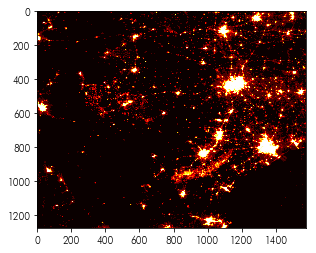

In [8]:
plt.imshow(nightlights, cmap='hot')

In [82]:
neighborhoods = geopandas.read_file('../data/neighborhoods.gpkg')

In [11]:
austin_bbox = neighborhoods.total_bounds

In [12]:
nightlight_file.window?

Signature: nightlight_file.window(left, bottom, right, top, precision=None)
Docstring:
Get the window corresponding to the bounding coordinates.

The resulting window is not cropped to the row and column
limits of the dataset.

Parameters
----------
left: float
    Left (west) bounding coordinate
bottom: float
    Bottom (south) bounding coordinate
right: float
    Right (east) bounding coordinate
top: float
    Top (north) bounding coordinate
precision: int, optional
    Number of decimal points of precision when computing inverse
    transform.

Returns
-------
window: Window
File:      ~/anaconda3/envs/ana/lib/python3.7/site-packages/rasterio/windows.py
Type:      method


In [13]:
austin_window = nightlight_file.window(*neighborhoods.total_bounds)

In [14]:
austin_nightlights = nightlight_file.read(1, window=austin_window)

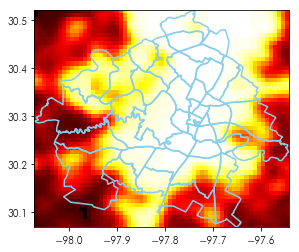

In [23]:
plt.imshow(austin_nightlights, extent=neighborhoods.total_bounds[[0,2,1,3]], cmap='hot')
neighborhoods.boundary.plot(ax=plt.gca(), color='skyblue')

In [210]:
austin_transform = nightlight_file.window_transform(austin_window)

In [211]:
with rasterio.open('../data/austinlights.tif', 'w', driver='GTiff', 
                   height=austin_nightlights.shape[0], 
                   width=austin_nightlights.shape[1], 
                   count=1, dtype=rasterio.ubyte, 
                   crs=nightlight_file.crs, 
                   transform=austin_transform) as outfile:
    outfile.write(austin_nightlights, 1)

In [59]:
tonermap, tonermap_extent = contextily.bounds2img(*neighborhoods.to_crs(epsg=3857).total_bounds, zoom=10, 
                                                  url=contextily.tile_providers.ST_TONER_LITE)

# Zonalstats

what's the average brightness at night within each of the neighborhoods?

In [26]:
from rasterio.mask import mask

array([-97.928875, -97.846623,  30.139555,  30.218407])

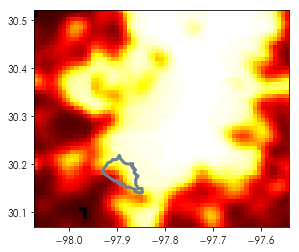

In [177]:
test_shape = neighborhoods.geometry[[0]]
plt.imshow(austin_nightlights, extent=neighborhoods.total_bounds[[0,2,1,3]], cmap='hot')
test_shape.boundary.plot(ax = plt.gca(), color='slategrey', linewidth=3)
ax.axis(test_shape.total_bounds[[0,2,1,3]])

In [161]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True)

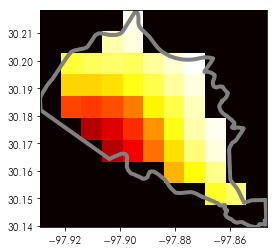

In [162]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

In [163]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True, all_touched=True)

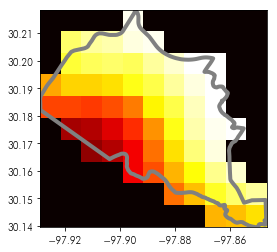

In [164]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

In [165]:
masked.mean()

24.490909090909092

In [167]:
masked

array([[[ 0,  0,  0,  0, 59,  0,  0,  0,  0,  0,  0],
        [ 0, 51, 54, 55, 58, 59,  0,  0,  0,  0,  0],
        [ 0, 48, 50, 51, 50, 54, 57, 60, 60,  0,  0],
        [37, 41, 41, 42, 46, 49, 54, 58, 60,  0,  0],
        [28, 28, 27, 29, 33, 44, 49, 56, 60,  0,  0],
        [ 0, 14, 15, 19, 26, 35, 46, 55, 59, 60,  0],
        [ 0,  0, 12, 15, 21, 32, 42, 52, 58,  0,  0],
        [ 0,  0,  0,  0, 21, 29, 38, 45, 53, 57,  0],
        [ 0,  0,  0,  0,  0,  0, 32, 39, 47, 51, 54],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 38, 39, 42]]], dtype=uint8)

In [168]:
masked[masked.nonzero()].mean()

43.45161290322581

In [186]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True, all_touched=True, 
                              filled=False)

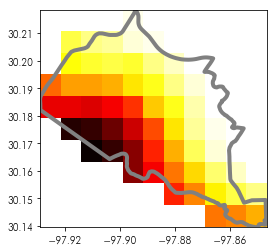

In [187]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

In [188]:
masked.mean()

43.45161290322581

In [195]:
neighborhoods['nightlights'] = neighborhoods.geometry.apply(lambda geom: mask(dataset=nightlight_file, 
                                               shapes=(geom, ), 
                                               crop=True, all_touched=True, 
                                               filled=False)[0].mean())

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

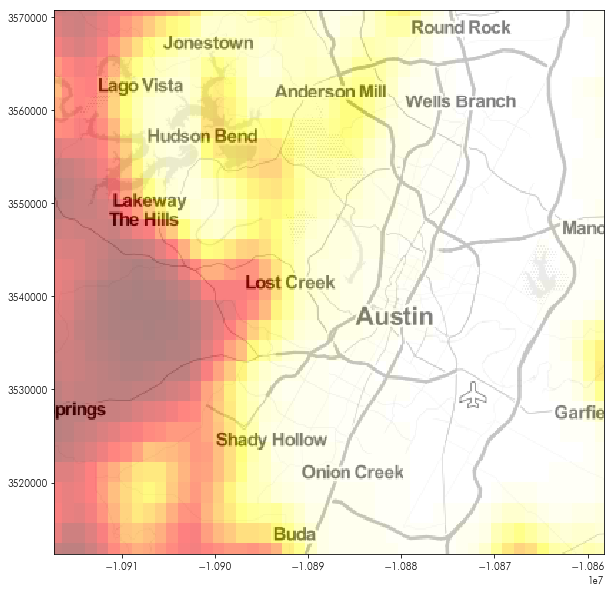

In [208]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent)
plt.imshow(austin_nightlights, extent=tonermap_extent, alpha=.5, cmap='hot')
plt.axis(neighborhoods.to_crs(epsg=3857).total_bounds[[0,2,1,3]])

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

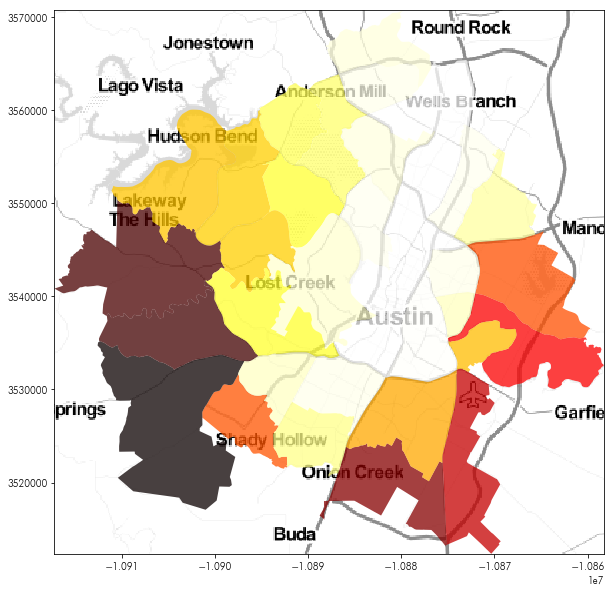

In [203]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent)
neighborhoods.to_crs(epsg=3857).plot('nightlights', 
                                     cmap='hot', ax = plt.gca(), alpha=.75)
plt.axis(neighborhoods.to_crs(epsg=3857).total_bounds[[0,2,1,3]])